# Domain Error Data Analysis
In this notebook, I will find out the best python modules to read in Domain data and carry out an exploratory analysis to understand problem.

In [70]:
import shapefile

In [71]:
sf = shapefile.Reader('./data/Ambiental_DataJavelin_FloodMap_QA/Domain_Errors/Domains/NOR_9_1_Domain.shp')


In [75]:
sf.shapes()[0].points[0]

(412706.3804254929, 621365.3729263357)

In [81]:
import matplotlib
from matplotlib.patches import Circle, Wedge, Polygon
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [82]:
patches=[Polygon(sf.shapes()[0].points, True)]


(620500.0, 622500.0000000019)

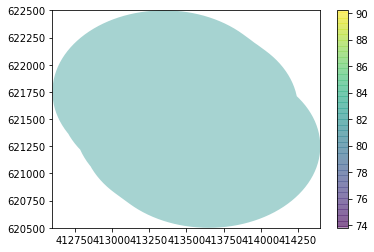

In [91]:
fig, ax = plt.subplots()

colors = 100*np.random.rand(len(patches))
p = PatchCollection(patches, alpha=0.4)
p.set_array(np.array(colors))
ax.add_collection(p)
fig.colorbar(p, ax=ax)
lims=sf.shapes()[0].bbox
plt.xlim(lims[0],lims[2])
plt.ylim(lims[1],lims[3])

In [92]:
import gdal

In [94]:
floodmap=gdal.Open('./data/Ambiental_DataJavelin_FloodMap_QA/Domain_Errors/CombinedOutput_FloodMap/NOR_Fluvial_100yr.tif')

In [95]:
arr = floodmap.ReadAsArray()

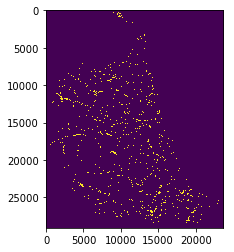

In [97]:
plt.imshow(arr)